<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задача" data-toc-modified-id="Задача-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задача</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ресемплирование</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#По-дням" data-toc-modified-id="По-дням-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>По дням</a></span></li><li><span><a href="#По-неделям" data-toc-modified-id="По-неделям-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>По неделям</a></span></li><li><span><a href="#По-месяцам" data-toc-modified-id="По-месяцам-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>По месяцам</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#По-дням-недели" data-toc-modified-id="По-дням-недели-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>По дням недели</a></span></li><li><span><a href="#По-часам" data-toc-modified-id="По-часам-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>По часам</a></span></li><li><span><a href="#По-дням-месяца" data-toc-modified-id="По-дням-месяца-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>По дням месяца</a></span></li><li><span><a href="#Разности-временного-ряда" data-toc-modified-id="Разности-временного-ряда-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>Разности временного ряда</a></span></li></ul></li><li><span><a href="#Выборки" data-toc-modified-id="Выборки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выборки</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>ElasticNet</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Результаты</a></span></li><li><span><a href="#Проверка-на-вменяемость" data-toc-modified-id="Проверка-на-вменяемость-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Проверка на вменяемость</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Прогнозирование заказов такси

## Задача

Имеются исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
!pip install lightgbm

In [41]:
import numpy as np
import pandas as pd
import seaborn as sb
import lightgbm as lgb
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

In [3]:
try:
    data = pd.read_csv('taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')

In [4]:
data

datetime  num_orders
0      2018-03-01 00:00:00           9
1      2018-03-01 00:10:00          14
2      2018-03-01 00:20:00          28
3      2018-03-01 00:30:00          20
4      2018-03-01 00:40:00          32
...                    ...         ...
26491  2018-08-31 23:10:00          32
26492  2018-08-31 23:20:00          24
26493  2018-08-31 23:30:00          27
26494  2018-08-31 23:40:00          39
26495  2018-08-31 23:50:00          53

[26496 rows x 2 columns]

Столбцы:
- datetime – дата и время фиксации
- num_orders – количество заказов такси

## Предобработка данных

На всякий случай проверим наличие пропусков и дубликатов.

In [5]:
data.duplicated().sum()

0

In [6]:
len(data['datetime'].unique())

26496

In [7]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

Поставим время в качестве индекса.

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

## Ресемплирование

Посчитаем сумму заказов за каждый час.

In [9]:
data = data.resample('1H').sum()
data

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

## Исследовательский анализ данных

In [10]:
data

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

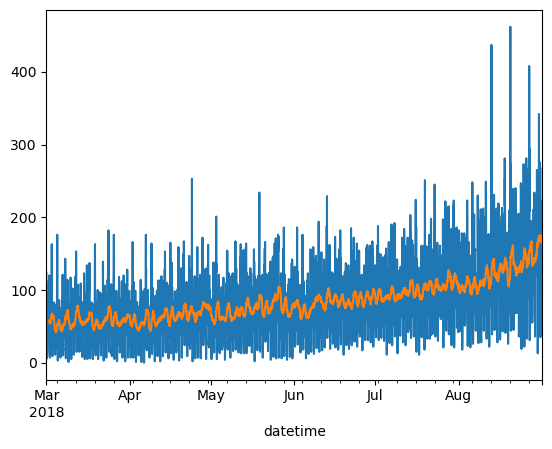

In [11]:
data['num_orders'].plot()
data['num_orders'].rolling(25).mean().plot() # за прошедшие сутки
plt.show()

### По дням

Посмотрим средние значения за день.

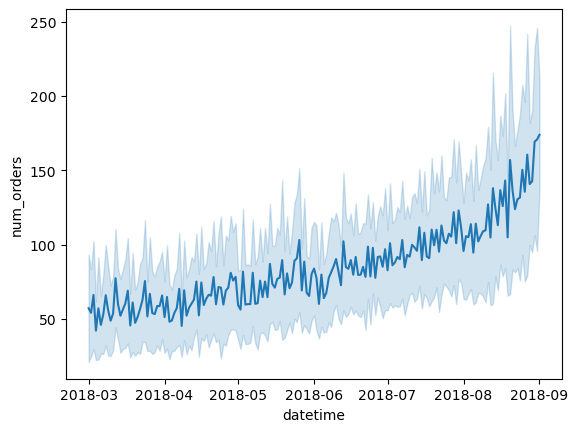

In [12]:
sb.lineplot(x=data.index.round('d'), y=data['num_orders'], estimator='mean', errorbar='sd')
plt.show()

Среднее явно растёт. Интересно было бы проверить месяцы на сезонность, но данных для этого, к сожалению, нет.

### По неделям

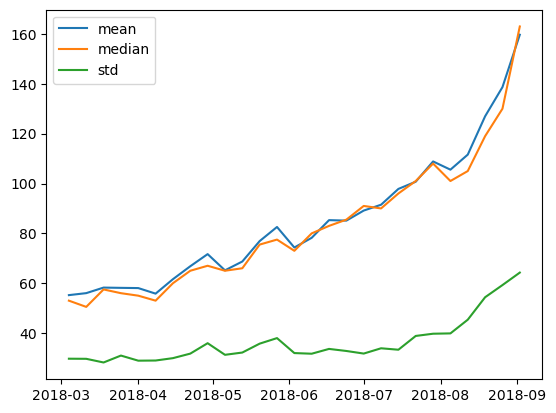

In [13]:
plt.plot(data['num_orders'].resample('1W').mean(), label='mean')
plt.plot(data['num_orders'].resample('1W').median(), label='median')
plt.plot(data['num_orders'].resample('1W').std(), label='std')
plt.legend()
plt.show()

### По месяцам

In [14]:
stat_by_month = data['num_orders'].resample('1M').agg(['count', 'mean', 'sum'])
stat_by_month.index = stat_by_month.index.month
stat_by_month

count        mean    sum
datetime                          
3           744   57.483871  42768
4           720   63.804167  45939
5           744   73.682796  54820
6           720   83.202778  59906
7           744  100.006720  74405
8           744  127.651882  94973

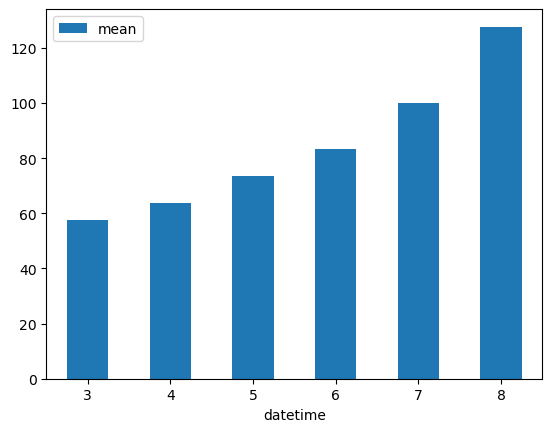

In [15]:
stat_by_month['mean'].plot(kind='bar')
plt.xticks(rotation=0)
plt.legend()
plt.show()

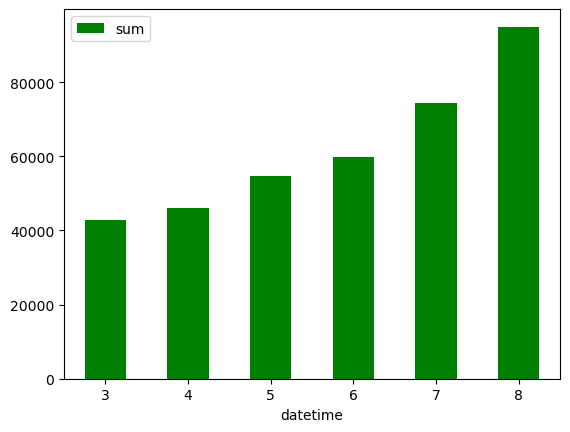

In [16]:
stat_by_month['sum'].plot(kind='bar', color='green')
plt.xticks(rotation=0)
plt.legend()
plt.show()

Думаю, этот признак пригодится при обучении.

### Тренды и сезонность

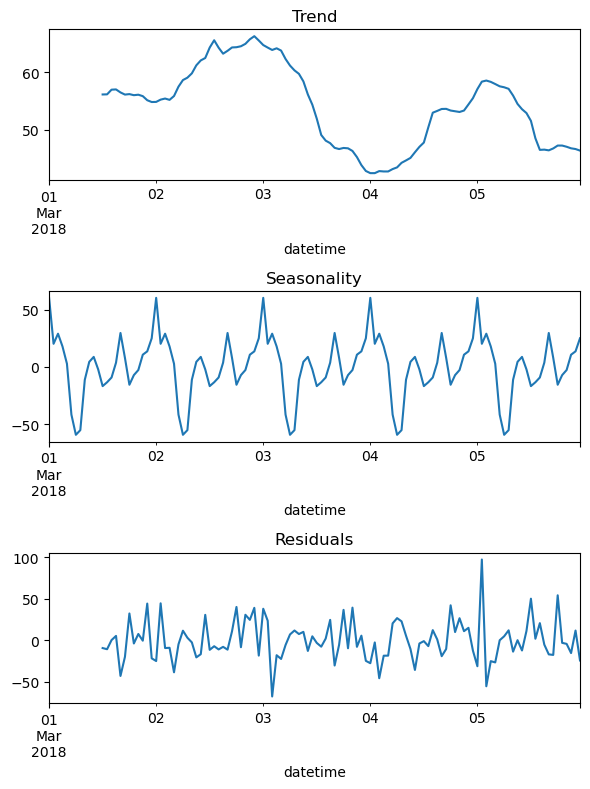

In [17]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Посмотрим на сезонность внутри недели.

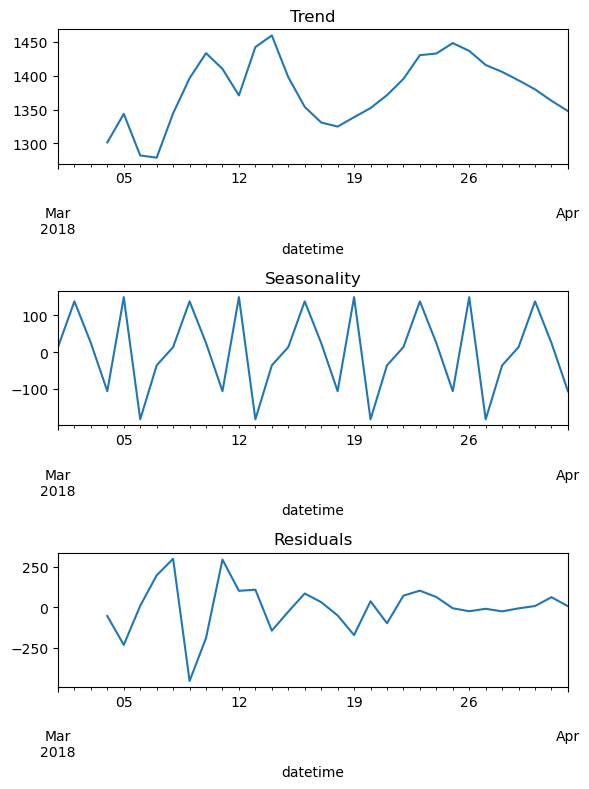

In [18]:
decomposed_by_day = seasonal_decompose(data.resample('1D').sum()['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_by_day.trend['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_by_day.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_by_day.resid['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Найдена ожидаемая сезонность по дням недели.

### По дням недели

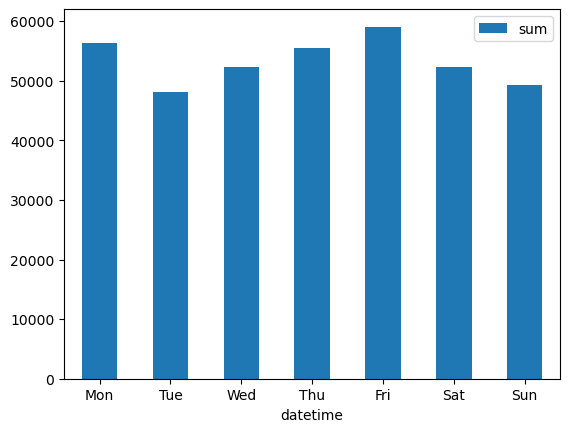

In [19]:
data.groupby(data.index.weekday)['num_orders'].agg(['sum']).plot(kind='bar')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

Выходные, наверное, ещё можно объяснить, а вот во вторник спад непонятный.

### По часам

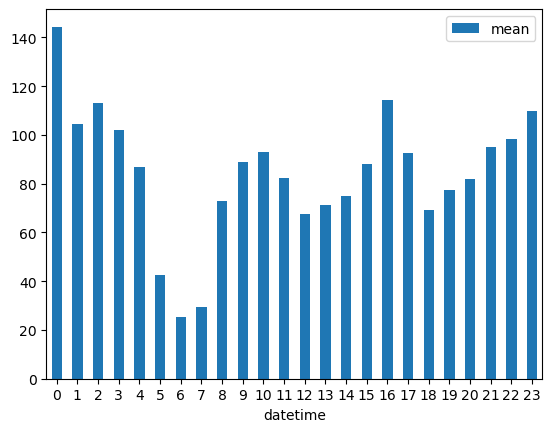

In [20]:
data.groupby(data.index.hour)['num_orders'].agg(['mean']).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Это существенная разница. Ранним утром рейсов немного.

### По дням месяца

Посмотрим на количество заказов по дням.

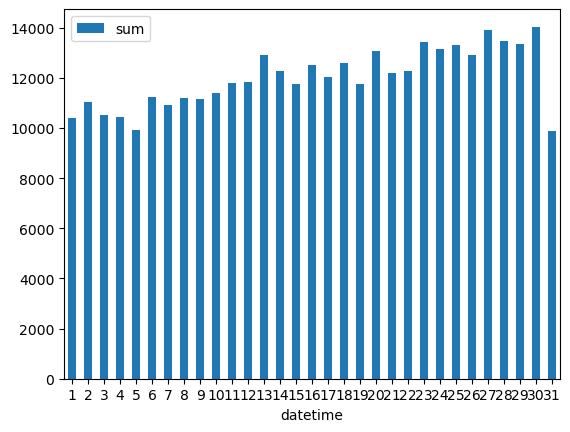

In [21]:
data.groupby(data.index.day)['num_orders'].agg(['sum']).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Спад для 31-го дня может быть вызван тем, что не во всех месяцах 31 день.

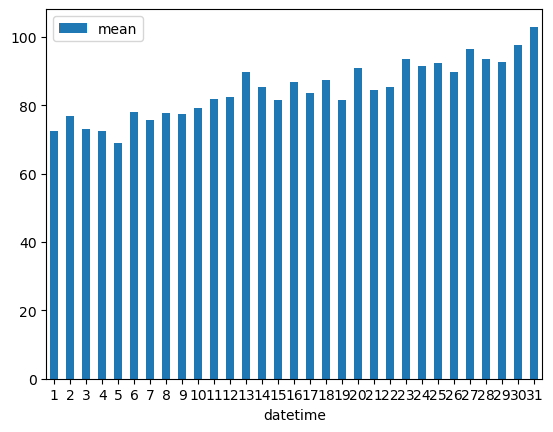

In [22]:
data.groupby(data.index.day)['num_orders'].agg(['mean']).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Ну да. Тем не менее, заметен небольшой рост, не очень пока объяснимый.

Посмотрим на апрель. Возможно, за март было мало данных.

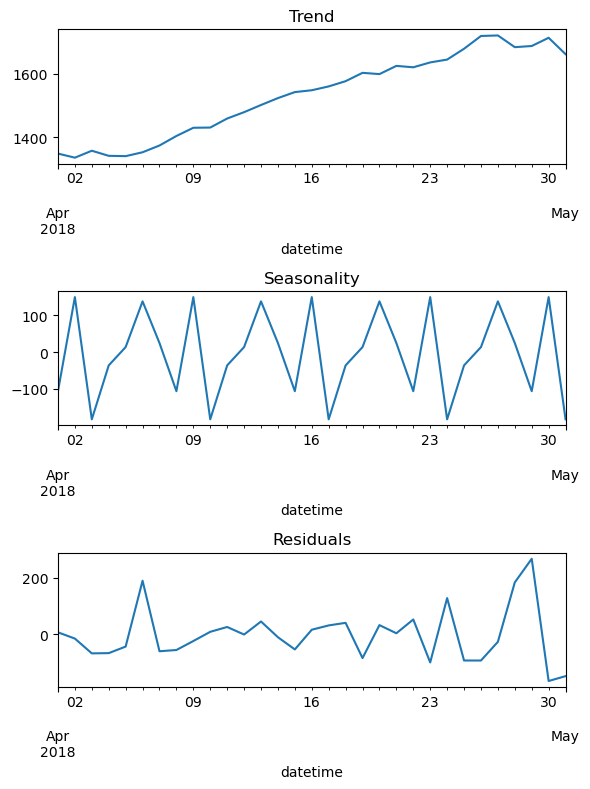

In [23]:
decomposed_by_day = seasonal_decompose(data.resample('1D').sum()['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_by_day.trend['2018-04-01':'2018-05-01'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_by_day.seasonal['2018-04-01':'2018-05-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_by_day.resid['2018-04-01':'2018-05-01'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

В общем-то тренд растущий.

Отсюда также видно, что сезонные колебания количества заказов не зависят от тренда.

### Разности временного ряда

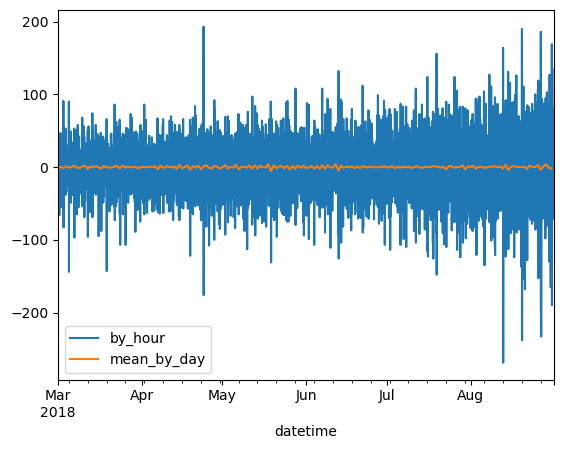

In [24]:
(data['num_orders'] - data['num_orders'].shift(1)).plot(
    label='by_hour')
(data['num_orders'] - data['num_orders'].shift(1)).resample('1D').mean().plot(
    label='mean_by_day')
plt.legend()
plt.show()

С предыдущим часом разницы нет.

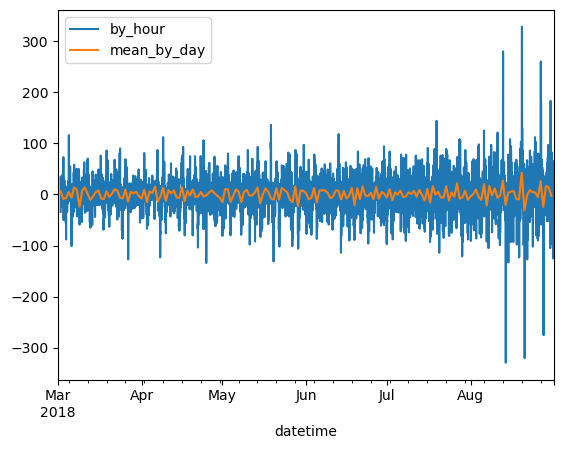

In [25]:
(data['num_orders'] - data['num_orders'].shift(24)).plot(
    label='by_hour')
(data['num_orders'] - data['num_orders'].shift(24)).resample('1D').mean().plot(
    label='mean_by_day')
plt.legend()
plt.show()

Сдвиг по дням более волатильный, но всё ещё в районе нуля.

Проверим стационарность тестом Дики-Фуллера.

In [26]:
result = adfuller(data)
print('Statistic:', round(result[0], 3))
print('Critical_values:')
for key, value in result[4].items():
    print(key, ':', round(value, 3))
print('p-value:', result[1])
if result[0] < result[4]['5%']:
    print('Rejecting H0: data is stationary (5% confidence)')
else:
    print('failed to rejct H0: data is not stationary (5% confidence)')

Statistic: -3.069
Critical_values:
1% : -3.432
5% : -2.862
10% : -2.567
p-value: 0.028940051402613506
Rejecting H0: data is stationary (5% confidence)


То есть с 5% точностью ряд стационарен.

## Выборки

In [27]:
data = pd.DataFrame(data['num_orders'])
data

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

In [28]:
data_train, data_test = train_test_split(data, shuffle=False, test_size=0.1)

Выделим следующие признаки для обучения:
- День недели (сезонность имеется)
- Час (есть суточная сезонность)
- Сдвиг по количеству заказов (в качестве параметра авторегрессии)
- Скользящее среднее (как аналог тренда)

In [32]:
def datasets(data, max_lag, rolling_mean_size, convert=False):
    # признаки
    data = pd.DataFrame(data)
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    
    for i in range(max_lag):
        data[f'lag_{i+1}'] = data.iloc[:,0].shift(i+1)
        
    data['rolling_mean'] = data.iloc[:,0].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    
    # выборки
    features = data.drop('num_orders', axis=1)
    target = data['num_orders']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, shuffle=False, test_size=0.2)
    
    features_train = features_train.copy()
    features_valid = features_valid.copy()
    
    # преобразование
    if convert:
        cat_features = ['hour', 'day_of_week']
        numeric_features = features_train.columns[~features_train.columns.isin(cat_features)]

        # масштабирование
        scaler = StandardScaler()
        scaler.fit(features_train.loc[:, numeric_features])
        
        features_train.loc[:, numeric_features] = scaler.transform(
            features_train.loc[:, numeric_features])
        features_valid.loc[:, numeric_features] = scaler.transform(
            features_valid.loc[:, numeric_features])
        
        # прямое кодирование
        features_train = pd.get_dummies(features_train, drop_first=True, 
                                        columns=cat_features)
        features_valid = pd.get_dummies(features_valid, drop_first=True, 
                                       columns=cat_features)
        common_columns = set(features_train.columns) & set(features_valid.columns)
        features_train = features_train.loc[:, list(common_columns)]
        features_valid = features_valid.loc[:, list(common_columns)]
        
    return features_train, features_valid, target_train, target_valid

Пример использования функции:

In [33]:
features_train, features_valid, target_train, target_valid = datasets(
    data_train['num_orders'], 3, 5)
print(data['num_orders'].shape)
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)
features_train

(4416,)
(3175, 6)
(794, 6)
(3175,)
(794,)


hour  day_of_week  lag_1  lag_2  lag_3  rolling_mean
datetime                                                                 
2018-03-01 05:00:00     5            3   43.0   66.0   71.0          77.8
2018-03-01 06:00:00     6            3    6.0   43.0   66.0          54.2
2018-03-01 07:00:00     7            3   12.0    6.0   43.0          39.6
2018-03-01 08:00:00     8            3   15.0   12.0    6.0          28.4
2018-03-01 09:00:00     9            3   34.0   15.0   12.0          22.0
...                   ...          ...    ...    ...    ...           ...
2018-07-11 07:00:00     7            2   81.0   77.0  153.0         116.0
2018-07-11 08:00:00     8            2   28.0   81.0   77.0          91.2
2018-07-11 09:00:00     9            2   76.0   28.0   81.0          83.0
2018-07-11 10:00:00    10            2  104.0   76.0   28.0          73.2
2018-07-11 11:00:00    11            2  101.0  104.0   76.0          78.0

[3175 rows x 6 columns]

In [34]:
features_train, features_valid, target_train, target_valid = datasets(
    data_train['num_orders'], 3, 5, convert=True)
print(data['num_orders'].shape)
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)
features_train

(4416,)
(3175, 33)
(794, 33)
(3175,)
(794,)


hour_4  hour_12  hour_11  hour_14  day_of_week_2  \
datetime                                                                
2018-03-01 05:00:00       0        0        0        0              0   
2018-03-01 06:00:00       0        0        0        0              0   
2018-03-01 07:00:00       0        0        0        0              0   
2018-03-01 08:00:00       0        0        0        0              0   
2018-03-01 09:00:00       0        0        0        0              0   
...                     ...      ...      ...      ...            ...   
2018-07-11 07:00:00       0        0        0        0              1   
2018-07-11 08:00:00       0        0        0        0              1   
2018-07-11 09:00:00       0        0        0        0              1   
2018-07-11 10:00:00       0        0        0        0              1   
2018-07-11 11:00:00       0        0        1        0              1   

                     hour_15  hour_21  hour_22  day_of_week_3  hour_20  ...  \
datetime                                                                ...   
2018-03-01 05:00:00        0        0        0              1        0  ...   
2018-03-01 06:00:00        0        0        0              1        0  ...   
2018-03-01 07:00:00        0        0        0              1        0  ...   
2018-03-01 08:00:00        0        0        0              1        0  ...   
2018-03-01 09:00:00        0        0        0              1        0  ...   
...                      ...      ...      ...            ...      ...  ...   
2018-07-11 07:00:00        0        0        0              0        0  ...   
2018-07-11 08:00:00        0        0        0              0        0  ...   
2018-07-11 09:00:00        0        0        0              0        0  ...   
2018-07-11 10:00:00        0        0        0              0        0  ...   
2018-07-11 11:00:00        0        0        0              0        0  ...   

                     hour_3  hour_17  hour_2  hour_18     lag_1  \
datetime                                                          
2018-03-01 05:00:00       0        0       0        0 -0.824197   
2018-03-01 06:00:00       0        0       0        0 -1.904347   
2018-03-01 07:00:00       0        0       0        0 -1.729188   
2018-03-01 08:00:00       0        0       0        0 -1.641608   
2018-03-01 09:00:00       0        0       0        0 -1.086936   
...                     ...      ...     ...      ...       ...   
2018-07-11 07:00:00       0        0       0        0  0.285147   
2018-07-11 08:00:00       0        0       0        0 -1.262096   
2018-07-11 09:00:00       0        0       0        0  0.139181   
2018-07-11 10:00:00       0        0       0        0  0.956592   
2018-07-11 11:00:00       0        0       0        0  0.869012   

                     day_of_week_4  day_of_week_5  hour_7  hour_9  hour_19  
datetime                                                                    
2018-03-01 05:00:00              0              0       0       0        0  
2018-03-01 06:00:00              0              0       0       0        0  
2018-03-01 07:00:00              0              0       1       0        0  
2018-03-01 08:00:00              0              0       0       0        0  
2018-03-01 09:00:00              0              0       0       1        0  
...                            ...            ...     ...     ...      ...  
2018-07-11 07:00:00              0              0       1       0        0  
2018-07-11 08:00:00              0              0       0       0        0  
2018-07-11 09:00:00              0              0       0       1        0  
2018-07-11 10:00:00              0              0       0       0        0  
2018-07-11 11:00:00              0              0       0       0        0  

[3175 rows x 33 columns]

In [35]:
print(sorted(features_train.columns))

['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour_1', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_2', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean']


## Обучение

Попробуем линейную регрессию, ElasticNet (как компромисс между Lasso и Ridge регрессиями) и LightGBM.

In [36]:
# функция для подбора гиперпараметров
def get_shift_and_size(data, model, convert=False):
    best_train_rmse = 1000
    best_test_rmse = 1000
    best_model = None
    best_shift = 0
    best_mean_size = 0
    for shift in [1, 12, 24]:
        for mean_size in [1, 12, 24, 48]:

            features_train, features_test, target_train, target_test = datasets(
                data, shift, mean_size, convert=convert)

            model = model

            model.fit(features_train, target_train)
            predictions_train = model.predict(features_train)
            predictions_test = model.predict(features_test)

            if mse(target_test, predictions_test)**0.5 < best_test_rmse:
                best_model = model
                best_shift = shift
                best_mean_size = mean_size
                best_train_rmse = mse(target_train, predictions_train)**0.5
                best_test_rmse = mse(target_test, predictions_test)**0.5

    # if best_model.__class__.__name__ != 'LinearRegression':
    try:
        print(best_model.best_params_)
    except:
        pass
    print('RMSE на тренировочной выборке:', best_train_rmse)
    print('RMSE на тестовой выборке:', best_test_rmse)
    print('Лучший сдвиг:', best_shift)
    print('Лучшее окно для скользящего среднего:', best_mean_size)
    
    return best_shift, best_mean_size

### Линейная регрессия

In [37]:
get_shift_and_size(data_train['num_orders'], LinearRegression())

RMSE на тренировочной выборке: 23.81484449120641
RMSE на тестовой выборке: 33.17746655136279
Лучший сдвиг: 24
Лучшее окно для скользящего среднего: 48


(24, 48)

In [38]:
get_shift_and_size(data_train['num_orders'], LinearRegression(), convert=True)

RMSE на тренировочной выборке: 20.800634354966395
RMSE на тестовой выборке: 30.376202604847297
Лучший сдвиг: 24
Лучшее окно для скользящего среднего: 48


(24, 48)

С маштабированием вроде бы лучше получается.

### ElasticNet

In [39]:
get_shift_and_size(data_train['num_orders'], ElasticNet(tol=0.01))

RMSE на тренировочной выборке: 23.818219199553607
RMSE на тестовой выборке: 33.1906677075976
Лучший сдвиг: 24
Лучшее окно для скользящего среднего: 48


(24, 48)

In [40]:
get_shift_and_size(data_train['num_orders'], ElasticNet(tol=0.01), convert=True)

RMSE на тренировочной выборке: 24.848837314387
RMSE на тестовой выборке: 34.401352614329255
Лучший сдвиг: 24
Лучшее окно для скользящего среднего: 48


(24, 48)

Тут, наоборот, масштабирование повредило.

### LightGBM

В случае с временными рядами при кросс-валидации выборки надо упорядочивать.

In [43]:
%%time
params_grid = {'learning_rate': [0.05, 0.1], 
               'n_estimators': [100, 300], 
               'colsample_bytree': [0.7, 1.0]}

model = GridSearchCV(estimator=lgb.LGBMRegressor(objective='regression', random_state=57), 
                     param_grid=params_grid, cv=TimeSeriesSplit(n_splits=3), 
                     scoring='neg_root_mean_squared_error')

get_shift_and_size(data_train['num_orders'], model)

{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'n_estimators': 100}
RMSE на тренировочной выборке: 15.006323350523274
RMSE на тестовой выборке: 30.562846978998806
Лучший сдвиг: 12
Лучшее окно для скользящего среднего: 48
CPU times: user 8min 26s, sys: 9.99 s, total: 8min 36s
Wall time: 1min 8s


(12, 48)

In [44]:
%%time
params_grid = {'learning_rate': [0.05, 0.1], 
               'n_estimators': [100, 300], 
               'colsample_bytree': [0.7, 1.0]}

model = GridSearchCV(estimator=lgb.LGBMRegressor(objective='regression', random_state=57), 
                     param_grid=params_grid, cv=TimeSeriesSplit(n_splits=3), 
                     scoring='neg_root_mean_squared_error')

get_shift_and_size(data_train['num_orders'], model, convert=True)

{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'n_estimators': 100}
RMSE на тренировочной выборке: 13.992191219128351
RMSE на тестовой выборке: 32.86110530555558
Лучший сдвиг: 24
Лучшее окно для скользящего среднего: 1
CPU times: user 11min 25s, sys: 18.4 s, total: 11min 43s
Wall time: 1min 35s


(24, 1)

## Результаты

Получаем следующую таблицу:
<a id='table'>
    
|Модель|Оптимальный сдвиг|Оптимальное окно среднего|RMSE|
|-|-|-|-|
|LinearRegression|24|48|30.38|
|ElasticNet|24|48|33.19|
|LightGBM|12|48|30.56|

</a>

Таким образом, на тестирование отправляется линейная регрессия.

## Проверка на вменяемость

In [45]:
# медианами
pred_median = np.ones(data_test['num_orders'].shape) * data_train['num_orders'].median()
print("RMSE:", mse(data_test['num_orders'], pred_median)**0.5)

RMSE: 87.15277582981295


In [46]:
# предыдущим значением
pred_previous = data_test['num_orders'].shift(
    fill_value=float(data_train['num_orders'].iloc[-1]))
print("RMSE:", mse(data_test['num_orders'], pred_previous)**0.5)

RMSE: 58.856486242815066


Вторая отсечка заметно строже.

## Тестирование

Тренировать будем и на тренировочной, и на валидационной выборках.

In [47]:
data_train

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-13 09:00:00         137
2018-08-13 10:00:00         156
2018-08-13 11:00:00         144
2018-08-13 12:00:00          92
2018-08-13 13:00:00         119

[3974 rows x 1 columns]

In [48]:
# признаки
data_train = data_train.copy()
data_test = data_test.copy()
for dataset in [data_train, data_test]:
    dataset['month'] = dataset.index.month
    dataset['day'] = dataset.index.day
    dataset['hour'] = dataset.index.hour
    dataset['day_of_week'] = dataset.index.dayofweek
    for i in range(20):
        dataset[f'lag_{i+1}'] = dataset['num_orders'].shift(i+1)
    dataset['rolling_mean'] = dataset['num_orders'].shift().rolling(48).mean()
    dataset.dropna(inplace=True)

In [49]:
# выборки
features_train = data_train.drop('num_orders', axis=1)
features_test = data_test.drop('num_orders', axis=1)
target_train = data_train['num_orders']
target_test = data_test['num_orders']

In [50]:
cat_features = ['month', 'day', 'hour', 'day_of_week']
numeric_features = features_train.columns[~features_train.columns.isin(cat_features)]

# масштабирование
scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric_features])
        
features_train.loc[:, numeric_features] = scaler.transform(
            features_train.loc[:, numeric_features])
features_test.loc[:, numeric_features] = scaler.transform(
            features_test.loc[:, numeric_features])
        
# прямое кодирование
features_train = pd.get_dummies(features_train, drop_first=True, 
                                        columns=cat_features)
features_test = pd.get_dummies(features_test, drop_first=True, 
                                       columns=cat_features)
common_columns = set(features_train.columns) & set(features_test.columns)
features_train = features_train.loc[:, list(common_columns)]
features_test = features_test.loc[:, list(common_columns)]

In [51]:
features_train

day_30  day_23  hour_4    lag_19    lag_15  hour_12  \
datetime                                                                   
2018-03-03 00:00:00       0       0       0 -1.763566 -0.873273        0   
2018-03-03 01:00:00       0       0       0 -1.763566 -0.636565        0   
2018-03-03 02:00:00       0       0       0 -1.868678  0.336565        0   
2018-03-03 03:00:00       0       0       0 -0.843839 -1.109980        0   
2018-03-03 04:00:00       0       0       1 -0.870116 -0.873273        0   
...                     ...     ...     ...       ...       ...      ...   
2018-08-13 09:00:00       0       0       0  0.680281 -0.005346        0   
2018-08-13 10:00:00       0       0       0  1.862787  0.099857        0   
2018-08-13 11:00:00       0       0       0  1.967899  0.520670        0   
2018-08-13 12:00:00       0       0       0  0.969338  1.493800        1   
2018-08-13 13:00:00       0       0       0 -0.002945  1.046686        0   

                     hour_11    lag_14  hour_14  day_20  ...    lag_13  \
datetime                                                 ...             
2018-03-03 00:00:00        0 -0.636926        0       0  ...  0.334434   
2018-03-03 01:00:00        0  0.335323        0       0  ... -1.110026   
2018-03-03 02:00:00        0 -1.109911        0       0  ... -0.873660   
2018-03-03 03:00:00        0 -0.873418        0       0  ... -0.899923   
2018-03-03 04:00:00        0 -0.899695        0       0  ... -0.505979   
...                      ...       ...      ...     ...  ...       ...   
2018-08-13 09:00:00        0  0.098830        0       0  ...  0.518274   
2018-08-13 10:00:00        0  0.519262        0       0  ...  1.490002   
2018-08-13 11:00:00        1  1.491510        0       0  ...  1.043533   
2018-08-13 12:00:00        0  1.044801        0       0  ...  2.803148   
2018-08-13 13:00:00        0  2.805359        0       0  ...  2.146575   

                     day_25  day_of_week_4  day_of_week_5  day_29     lag_8  \
datetime                                                                      
2018-03-03 00:00:00       0              0              1       0  0.091139   
2018-03-03 01:00:00       0              0              1       0  0.117009   
2018-03-03 02:00:00       0              0              1       0  0.272231   
2018-03-03 03:00:00       0              0              1       0 -0.762579   
2018-03-03 04:00:00       0              0              1       0  0.375712   
...                     ...            ...            ...     ...       ...   
2018-08-13 09:00:00       0              0              0       0  5.032355   
2018-08-13 10:00:00       0              0              0       0  9.275075   
2018-08-13 11:00:00       0              0              0       0  2.315980   
2018-08-13 12:00:00       0              0              0       0  1.669224   
2018-08-13 13:00:00       0              0              0       0  0.117009   

                     hour_7  day_28  hour_9  hour_19  
datetime                                              
2018-03-03 00:00:00       0       0       0        0  
2018-03-03 01:00:00       0       0       0        0  
2018-03-03 02:00:00       0       0       0        0  
2018-03-03 03:00:00       0       0       0        0  
2018-03-03 04:00:00       0       0       0        0  
...                     ...     ...     ...      ...  
2018-08-13 09:00:00       0       0       1        0  
2018-08-13 10:00:00       0       0       0        0  
2018-08-13 11:00:00       0       0       0        0  
2018-08-13 12:00:00       0       0       0        0  
2018-08-13 13:00:00       0       0       0        0  

[3926 rows x 66 columns]

In [52]:
target_test

datetime
2018-08-15 14:00:00    107
2018-08-15 15:00:00    103
2018-08-15 16:00:00    219
2018-08-15 17:00:00    165
2018-08-15 18:00:00     96
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 394, dtype: int64

In [53]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('RMSE:', mse(target_test, predictions_test)**0.5)

RMSE: 42.52760248760596


RMSE <= 48, значит тестирование пройдено.

## Вывод

1. Статистические закономерности
- Данными охвачен период с 1 марта по 31 августа 2018 года
- Количество заказов растёт на всём временном промежутке
- Наблюдается периодичность по часам в течение дня. Меньше всего заказов в 5, 6 и 7 часов утра.
- Также есть периодичность по неделям. По вторникам и выходным заказов меньше.
- Данные распределены стационарно.
2. Обучение моделей
- Были опробованы линейная регрессия, ElasticNet и LightGBM.
- Модели обучались на днях недели, часах, скользящем среднем и авторегрессионном сдвиге.
- Лучшая RMSE получилась при сдвиге в 24 часа и скользящем окне в 48 часов.
- Все модели прошли проверку на вменяемость (RMSE < 58.86).
- Лучше всех себя показала линейная регрессия, однако [разница](#table) небольшая.
- При тестировании модель показала RMSE = 42.53